# Plan
## This notebook
1. Super-quick intro into BaBar DIRC subdetector
2. You create a WGAP-GP GAN

___Congradulations on making it to level two of GAN practice!___

Here is a bonus: a relaxing link to play with advanced GANs without writing code:
* https://affinelayer.com/pixsrv/

# BaBar DIRC
![DIRC scheme](https://www.slac.stanford.edu/BFROOT/www/Detector/DIRC/Gifs/NewDirc.gif)

Detection of Internally Reflected Cherenkov light - a particle identification detector in other words. Unlike the calorimeter GANs, we will only generate high-level observables (particle delta log-likelihoods (DLL)) that are obtained after the reconstruction.

We want the generation to be conditional on full kinematics of event: energy, pseudorapidity and the distance between the particle track and DIRC bar side of signal particle. For the data-driven GAN this is just 11-D tabular data.

The data were generated with [FastDIRC](https://github.com/jmhardin/FastDIRC) modified to simulate two particle-events.

### Task 1 (difficulty: a couple of years ago this would have been a [paper](https://www.sciencedirect.com/science/article/pii/S0168900219300701) in a good journal, now should be doable in 10-40 minutes*)
\* after Denis Derkach formulated the problem and I did all the dirty work of getting training data

Create a conditional Jensen-Shannon GAN to generate Y given X

### Task 2 (difficulty: ~5 lines of code after completing task 1)

Create a conditional classical Wasserstein GAN wth gradient penalty to generate Y given X

__Note__: Task 2 is easier to code and train than task 1.

In [3]:
import requests
import re


URL_RE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
url_scrabber = re.compile(r'\s*<input type="hidden" name="downloadURL" '
                          'value="(?P<download_url>' + URL_RE + ')" '
                          'id="downloadURL">')

def get_cernbox_direct_link(url):
  guard_page = requests.get(url)
  for line in guard_page.text.split('\n'):
      match = url_scrabber.match(line)
      if match:
        return match.group('download_url')
  raise RuntimeError("downloadURL not found. Most likely case is a change in CERNBox")

In [4]:
# As usual the data is availbale in CoCalc. But if it is not, here is the link
# data_url = get_cernbox_direct_link("https://cernbox.cern.ch/index.php/s/hWCh4umYQ0KShjW")
DATA_FILE_NAME = '/home/user/share/data/4.10.1-advanced-GANs/kaons.hdf'

In [5]:
#! wget "$data_url" -O "$DATA_FILE_NAME" -nc

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, kstest
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [7]:
data = pd.read_hdf(DATA_FILE_NAME)
data.head()

,dll_electron,dll_kaon,dll_muon,dll_proton,dll_bt,particle_one_energy,particle_two_energy,particle_one_eta,particle_two_eta,particle_one_x,particle_two_x
48609366,-0.212708,2.314453,0.404724,-8.901489,-395.625427,5.761642,7.775553,-0.101042,-1.170546,4.806355,11.518691
85800802,-0.975586,7.093811,-0.254272,-118.109131,-125.633118,2.952495,4.515579,-1.027812,1.425283,8.347982,12.483961
48063890,1.210968,1.983414,-0.938339,-3.278305,-201.828049,5.667168,6.883764,0.243560,0.688672,9.765896,1.966456
6662551,-0.033142,1.237122,0.060791,0.109146,-196.228241,6.988772,4.271856,-1.019691,-0.693035,14.185906,15.605581
89492993,0.239120,3.052887,-0.522217,-22.034760,-268.287598,5.403506,8.019310,0.975898,1.015718,6.350332,4.286400


In [8]:
Y_COLUMNS = ["particle_one_energy",
             "particle_two_energy",
             "particle_one_eta",
             "particle_two_eta",
             "particle_one_x",
             "particle_two_x"]
X_COLUMNS = ["dll_electron",
             "dll_kaon",
             "dll_muon",
             "dll_proton",
             "dll_bt"]
assert X_COLUMNS + Y_COLUMNS == list(data.columns)

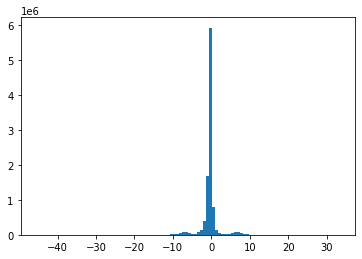

In [9]:
# If feel physically inclined, feel free to make a hundred of plots.
# However, for purposes of this exercise, abstract tabular X, Y will suffice.
# In order to achive this wonderful state, the data needs to be normalized.
plt.hist(data.values[:, 0], bins=100);

In [10]:
# Please use the sklearn.preprocessing.QuantileTransformer to transform each feature
# into a Gaussian

from sklearn.preprocessing import QuantileTransformer
# Will take a couple of minutes
# Please use the data_transformed variable to store the transfored dataset
qt = QuantileTransformer(n_quantiles=10000, output_distribution='normal', random_state=42)
data_transformed = qt.fit_transform(data)

After the transformation, features should look like this:
![feature after normalization](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/gauss.png)

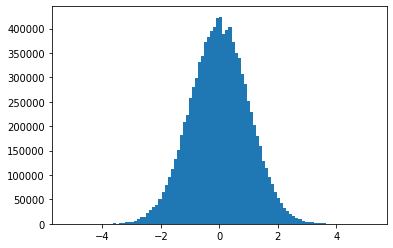

In [11]:
plt.hist(data_transformed[:, 0], bins=100);

In [12]:
assert data_transformed.shape == data.shape
for feature in range(data_transformed.shape[1]):
    assert kstest(data_transformed[:, feature], 'norm').statistic < 1e-2

In [13]:
train, test = train_test_split(data_transformed, test_size=0.1, random_state=124124)

In [14]:
LATENT_DIM = 64

Please create a fully-connected generator. Remember, we need a conditional GAN, so the generator input should have dimensions for Y and noise; output - for X.

You can start with a small one, make sure the code works, then add more layers. Having 3 hidden layer with 64 neurons in each should suffice.

In [16]:
# Note that WGAN does not work well with ELU (as per my experience and the original paper)
gen = nn.Sequential(nn.Linear(data.shape[1], 64), nn.LeakyReLU(),
                     nn.Linear(64, 64), nn.LeakyReLU(),
                     nn.Linear(64, 64), nn.LeakyReLU(),
                     nn.Linear(64, 1)).cuda()
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=1e-2)
gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(gen_opt, milestones=[10000, 30000], gamma=0.1)

In [17]:
assert gen[0].in_features == LATENT_DIM + len(Y_COLUMNS)
assert gen[-1].out_features == len(X_COLUMNS)

AssertionError: 

Please create a fully-connected discriminator. You can start with a small one, make sure the code works, then add more layers. Having 3 hidden layer with 64 neurons in each should suffice.

In [18]:
disc = nn.Sequential(nn.Linear(data.shape[1], 64), nn.LeakyReLU(),
                     nn.Linear(64, 64), nn.LeakyReLU(),
                     nn.Linear(64, 64), nn.LeakyReLU(),
                     nn.Linear(64, 1)).cuda()

disc_opt = torch.optim.RMSprop(disc.parameters(), lr=1e-2)
disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(disc_opt, milestones=[10000, 30000], gamma=0.1)

In [19]:
assert disc[0].in_features == data.shape[1]
assert disc[-1].out_features == 1

In [20]:
TRAIN_BATCH_SIZE = 1024
def sample_real_data(batch_size):
  """
  Inifintly repeats and shuffles the train dataset, outputs the
  result in delicious batches.
  """
  while True:
    dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                             shuffle=True, drop_last=True)
    for batch in dataloader:
        yield batch
infinite_data = sample_real_data(TRAIN_BATCH_SIZE)

Write a function that would sample the generator for given Y. The function should return a GPU-based tensor.

`concatenate(generator(concatenate(noise, y)), y)`

In [21]:
# sample_gen_data(y)
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [22]:
test_sample = sample_gen_data(torch.from_numpy(train[:3, len(X_COLUMNS):]).cuda())

NameError: name 'sample_gen_data' is not defined

In [23]:
assert test_sample.shape == (3, data.shape[1])

NameError: name 'test_sample' is not defined

In [24]:
# https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py
def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
    """
    Computes Gradient Penalty in random interpolates, in its classic form:
    (|∇(D(x)|^2 - 1)^2, x is interpolated between a real and a generated sample
    Args:
    critic: a torch model whose gradient needs to be penalised
    real_data[batch_size, n_features]: a sample of real data
    fakse_data[batch_size, n_features]: a sample of fake data
    Returns:
    torch.Tensor, scalar, gradient penalty evalute
    """
    assert real_data.shape == fake_data.shape
    alpha = torch.rand(real_data.shape[0], 1)
    alpha = alpha.expand(real_data.size()).cuda()

    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(
      outputs=disc_interpolates, inputs=interpolates,
      grad_outputs=torch.ones(disc_interpolates.size(), device="cuda"),
      create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [25]:
LAMBDA = 1.
def train_disc(gan_type="WGAN-GP"):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    real_data = next(infinite_data).to("cuda")
    y_gen = next(infinite_data)[:, len(X_COLUMNS):].to("cuda")
    gen_data = sample_gen_data(y_gen)

    if gan_type == "JS":
        logp_real_is_real = F.logsigmoid(disc(real_data))
        logp_gen_is_fake = F.logsigmoid(-disc(gen_data))
        disc_loss = -logp_real_is_real.mean() - logp_gen_is_fake.mean()
    elif gan_type == "WGAN-GP":
        disc_loss = disc(real_data).mean() - disc(gen_data).mean() + \
                  calc_gradient_penalty_classic(disc, real_data, gen_data)*LAMBDA
    else:
        raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP")

    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss

In [26]:
def train_gen(gan_type="WGAN-GP"):
    """Trains generator for one step"""
    real_data_y = next(infinite_data)[:, len(X_COLUMNS):].to("cuda")
    gen_data = sample_gen_data(real_data_y)

    if gan_type == "JS":
        # gen_loss = <your code here>
        # YOUR CODE HERE
        raise NotImplementedError()
    elif gan_type == "WGAN-GP":
        # gen_loss = <your code here>
        ### BEIGN SOLUTION
        gen_loss = disc(gen_data).mean()

    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [27]:
import os
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_LOGDIR = "./logs"
MODEL_NAME = "DIRCv1"
summary_writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOGDIR, MODEL_NAME))

In [28]:
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
VALIDATION_INTERVAL = 256
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]

data_linspace_np = np.linspace(0, 10, num=256, dtype=np.float32)
data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None].cuda()
validation_data = torch.from_numpy(test).cuda()
validation_data_np = test
validation_y = validation_data[:, len(X_COLUMNS):]

for i in range(10000):
    for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
        disc_loss_this_iter = train_disc()

    gen_loss_this_iter = train_gen()
    gen_scheduler.step()
    disc_scheduler.step()
    summary_writer.add_scalar("discriminator loss", disc_loss_this_iter,
                              global_step=i)
    summary_writer.add_scalar("generator loss", gen_loss_this_iter,
                              global_step=i)
    if i % VALIDATION_INTERVAL == 0:
        clear_output(True)
        validation_generated = sample_gen_data(validation_y)
        validation_generated_np = validation_generated.data.cpu().numpy()

        fig, axes_list = plt.subplots(ncols=5, figsize=[6*len(Y_COLUMNS), 6])
        for index, ax in enumerate(axes_list):
          ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
          ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Real', bins=HIST_BINS)
          ax.set_xlabel(data.columns[index])
          ks_result = ks_2samp(validation_generated_np[:, index],
                                    validation_data_np[:, index])
          ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
        fig.suptitle("Iteration {}".format(i))
        plt.show()

NameError: name 'sample_gen_data' is not defined

After a little bit of training, the plots should look like this: ![semitrained GAN](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/semi-trained.png)

If you want to push precision to the limit, you want to increase batch size and reduce learning rate over time. You'll also need to monitor the validation losses to avoid overfitting.

P. S.
As you know from the [lectures](https://en.pelican.study/classroom/213/dialogs/2614/run/), these plots do not comprehensively describe the quality of the GAN. Feel free to add better quality measures.